In [1]:
# get the Dataset:

import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

t0 = time.time()
# load data from the .mat file:
# mat_contents = sio.loadmat('EEG_big.mat') # (EEG_data.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/EEG_big4CNN.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/EEG_big4CNN_1subj.mat')



# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/KOS_100Hz_ICA->0.5-38Hz,Env=1.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/KOS_100Hz_noICA->0.5-38Hz,Env=1.mat')

# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->0.5-38Hz,Env=1_143_202.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->0.5-38Hz,Env=1_75_134.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->0.5-38Hz,Env=1_5_64.mat')

# winsize = mat_contents['winsize']
# stepsize = mat_contents['stepsize']
# trial_len = mat_contents['trial_len']
# low_cutoff = mat_contents['low_cutoff']
# high_cutoff = mat_contents['high_cutoff']
# source = mat_contents['filein']

path = '/home/amplifier/home/DATASETS/'
file = 'Merged456-197-289_ICA(ANDeyes)+AUDpreproc.mat, DS2=64Hz, FIR=2-30Hz, centnorm=1, step=2, win=2, TD, 1-93.mat'
# file = 'Merged456-197-289_ICA(ANDeyes)+AUDpreproc.mat, DS2=250Hz, FIR=2-30Hz, centnorm=1, step=2, win=2, TD, 1-93.mat' #0.89
mat_contents = sio.loadmat(path + file)

X = mat_contents['X']
Y = mat_contents['Z'].T
Y = Y.transpose(1,0)

# verify that the model REALLY finds a mapping between the input and the labels. If we get
# our accuracy by chance, then we should get the same accuracy on a permuted dataset:
# Y = np.random.permutation(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

# normalize to unit variance and zero mean:
for i in range(x_train.shape[0]):
    x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
    x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)

for i in range(x_test.shape[0]):
    x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
    x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)


# ensure the tensors are sized right:
x_train = np.transpose(x_train,(0,2,1))
x_test = np.transpose(x_test,(0,2,1))

# one hot encode the labels:
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train)
y_test = onehot_encoder.fit_transform(y_test)

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')
print('Normalized data type:', x_train.dtype)

print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

# print('Window length', winsize)
# print('Step size:', stepsize)
# print('Length of trial during experiment', trial_len)
# print('Low cutoff freq.', low_cutoff)
# print('High cutoff freq.', high_cutoff)
# print('Source data file:', source)

leng = x_test.shape[1]

Original data type: float32
Normalized data type: float16
test input shape (90, 128, 60) Nomralized MEAN: 0.5215 min 0.0 max 1.0
train input shape (360, 128, 60) Nomralized MEAN: 0.5215 min 0.0 max 1.0
test labels shape (90, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
train labels shape (360, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0


In [36]:
######################################################################

# http://cs231n.github.io/convolutional-networks/#case
# we first define the autoencoder's architecture:

# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D, ELU, SeparableConv1D
from keras.layers.advanced_activations import LeakyReLU

def activation():
    return ELU(alpha=1.0) # Activation('relu') #

from keras.models import Model
from keras.models import load_model
from keras.callbacks import TensorBoard, EarlyStopping, Callback
from keras import optimizers
from keras.initializers import Orthogonal as orth
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

# enc = load_model("/home/amplifier/home/NEW_DL/models/CNN_encoder_model.h5")

nb_filters = 50
kernel_size = [40,13,6]
dense1_n = 10

def Encoder():

    input_img = Input(shape=(leng, 60))
    inputbn = BatchNormalization(axis = 1)(input_img) ###########################################why this axis?

    convolved = Conv1D(nb_filters, kernel_size[0], padding="same",
                      kernel_initializer = orth(gain=1.0, seed=None))(inputbn)
    activated = activation()(convolved)
    dropout1 = Dropout(0.1)(activated)
    convolvedbn = BatchNormalization()(dropout1)
    pooled = MaxPooling1D()(convolvedbn)

    convolved2 = Conv1D(nb_filters*2, kernel_size[1], padding="same",
                       kernel_initializer = orth(gain=1.0, seed=None))(pooled)
    activated2 = activation()(convolved2)
    dropout2 = Dropout(0.2)(activated2)
    convolved2bn = BatchNormalization()(dropout2)
    pooled2 = MaxPooling1D()(convolved2bn)

    convolved3 = Conv1D(nb_filters*4, kernel_size[2], padding="same",
                       kernel_initializer = orth(gain=1.0, seed=None))(pooled2)
    activated3 = activation()(convolved3)
    dropout3 = Dropout(0.3)(activated3)
    convolved3bn = BatchNormalization()(dropout3)
    pooled3 = MaxPooling1D()(convolved3bn)

    flat = Flatten()(pooled3)

    dense1 = Dense(dense1_n, activation='sigmoid')(flat)
    dense1bn = BatchNormalization()(dense1)
    dense1do = Dropout(0.5)(dense1bn)

    out = Dense(2, activation='softmax')(dense1do)

    return Model(input_img, out)


enc = Encoder()
enc.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(0.00001), metrics=["accuracy"])
   
enc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 60)           0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 128, 60)           512       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 128, 50)           120050    
_________________________________________________________________
elu_10 (ELU)                 (None, 128, 50)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 128, 50)           0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 128, 50)           200       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 64, 50)            0         
__________

Layer number: 2 Layer name: conv1d_20
(40, 60, 50)


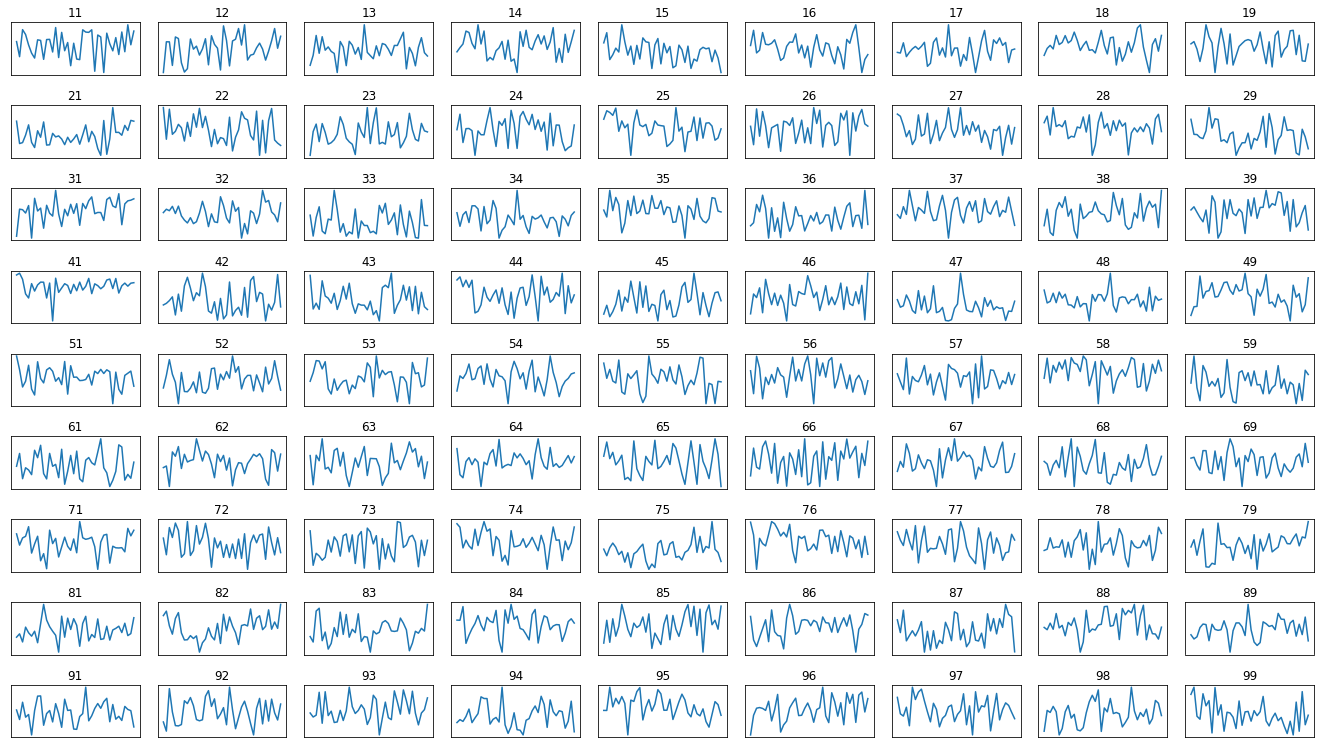

In [37]:
# Visualize a few kernels from the first convolutional layer:
# enc.layers[2].get_config()
# dir(enc.layers[2])
x = enc.layers[2].get_weights()
print ('Layer number:', 2, 'Layer name:', enc.layers[2].name)
print(x[0].shape) # kernel length x input channels x output channels

c = 0
fig, axs = plt.subplots(9,9)
fig.set_size_inches(18.5, 10.5)
axs = axs.ravel()
for i in range(1,10):
    for j in range(1,10):
        axs[c].plot(x[0][:,i,j])
        axs[c].get_xaxis().set_visible(False)
        axs[c].get_yaxis().set_visible(False)        
        axs[c].set_title(str(i)+str(j))
        c = c + 1
plt.tight_layout()

In [ ]:
##########################################################
init_lr = 0.00005
lr_drop_by = 0.995
drop_every = 5

# Training time!
# Try 20 epochs using batch size = 3, then switch to 4
from keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, Callback, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=100, mode='min')

K.set_value(enc.optimizer.lr, init_lr)

def step_decay(epoch, init_lr=init_lr, lr_drop=lr_drop_by, drop_every=drop_every):
    if epoch%drop_every==0:
        lrate = init_lr * (lr_drop_by ** np.floor((1+epoch)/drop_every))
    else:
        lrate = K.get_value(enc.optimizer.lr)
    print('CHECK', epoch%drop_every)
    return lrate

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.batch_loss = []
        self.val_acc = []
 
    def on_epoch_end(self, epoch, batch, logs={}):
        lrate = step_decay(epoch)
        txt = K.get_value(enc.optimizer.lr)
        self.lr.append(txt)
#         self.lr.append(lrate)
#         txt = K.eval(self.model.optimizer.lr)
        print('OPTIMIZERS lrate AT EPOCH END = ', txt, '\n\n')
    
    def on_epoch_begin(self, epoch, batch, logs={}):
        txt = K.get_value(enc.optimizer.lr)
        print('OPTIMIZERS lrate AT EPOCH START = ', txt)

    def on_batch_end(self, batch, logs={}):
        self.batch_loss.append(logs.get('loss'))

lr_decay = LearningRateScheduler(schedule=step_decay)
loss_history = LossHistory()

checkpointer = ModelCheckpoint(filepath='/home/amplifier/home/NEW_DL/weights/EEGnet_CNN+Dense_Binary_Classifier-Conv1_wts.h5',
                               verbose=1,
                               monitor='val_acc',
                               save_best_only=True)

train_history = enc.fit(x_train, y_train,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[checkpointer, early_stopping, lr_decay, loss_history])

# save the entire model and the weights after the training:
# enc.save('/home/amplifier/home/NEW_DL/models/EEGnet.h5')
# enc.save_weights('/home/amplifier/home/NEW_DL/weights/EEGnet_weights.h5')

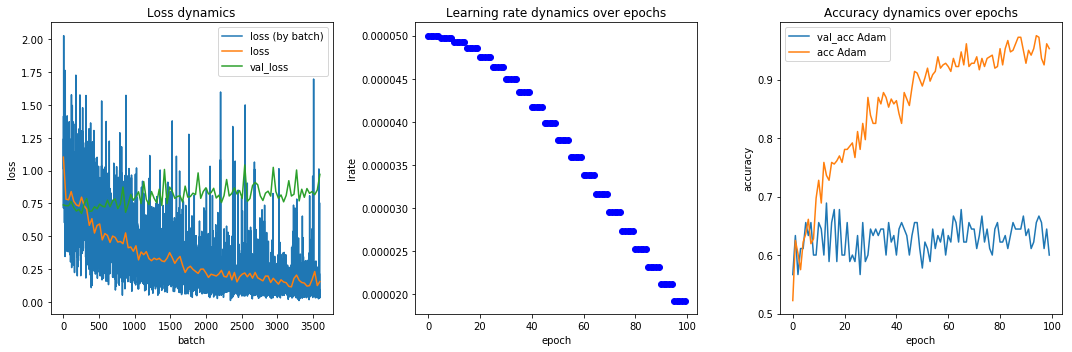

In [39]:
f, axs = plt.subplots(1,3,figsize=(15,5))
plt.subplot(131)
plt.plot(loss_history.batch_loss)
tic = np.linspace(0, len(loss_history.batch_loss), len(train_history.history['val_loss']))
plt.plot(tic, train_history.history['loss'])
plt.plot(tic, train_history.history['val_loss'])
plt.title('Loss dynamics')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['loss (by batch)', 'loss', 'val_loss'])

plt.subplot(132)
plt.plot(loss_history.lr,'bo')
plt.title('Learning rate dynamics over epochs')
plt.ylabel('lrate')
plt.xlabel('epoch')

asa = []
optimizer_name = enc.optimizer.__class__.__name__
plt.subplot(133)
plt.plot(train_history.history['val_acc'])
plt.plot(train_history.history['acc'])
asa.append('val_acc ' + optimizer_name)
asa.append('acc ' + optimizer_name)
plt.title('Accuracy dynamics over epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(asa)

plt.tight_layout()

In [40]:
enc.load_weights('/home/amplifier/home/NEW_DL/weights/EEGnet_CNN+Dense_Binary_Classifier-Conv1_wts.h5')

decoded_train = enc.predict(x_train)
decoded_test = enc.predict(x_test)
print(decoded_train.shape)
print(decoded_test.shape)

(360, 2)
(90, 2)


In [43]:
# now test sample by sample
cor_test = []
L = x_test.shape
for sample_no in range(x_test.shape[0]):
    pred = enc.predict(np.expand_dims(x_test[sample_no],0))
    if ((pred[0][0]<pred[0][1]) and (y_test[sample_no,0] < y_test[sample_no,1]) or
       ((pred[0][0]>pred[0][1]) & (y_test[sample_no,0] > y_test[sample_no,1]))):
        cor_test.append(1)
    else:
        cor_test.append(0)

cor_train = []
L = x_train.shape
for sample_no in range(x_train.shape[0]):
    pred = enc.predict(np.expand_dims(x_train[sample_no],0))
    if ((pred[0][0]<pred[0][1]) and (y_train[sample_no,0] < y_train[sample_no,1]) or
       ((pred[0][0]>pred[0][1]) & (y_train[sample_no,0] > y_train[sample_no,1]))):
        cor_train.append(1)
    else:
        cor_train.append(0)

# Report accuracies
print('Accuracy on the test data:', np.mean(cor_test))
print('Accuracy on the training data:', np.mean(cor_train))
t1 = time.time()
print('Elapsed', t1-t0, 'seconds')

Accuracy on the test data: 0.6888888888888889
Accuracy on the training data: 0.8583333333333333
Elapsed 8868.31851029396 seconds


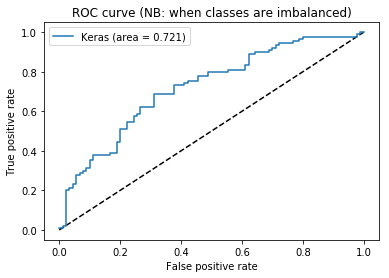

In [44]:
from sklearn.metrics import roc_curve, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.ravel(), decoded_test.ravel())
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (NB: when classes are imbalanced)')
plt.legend(loc='best')
plt.show()